Ticker selections
=================

In [1]:
# If you would like to refresh your data, please execute the bellow codes.

import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

from mypo import Loader

DOWNLOAD = False

if DOWNLOAD:
    tickers = pd.read_csv("/app/docs/tutorial/tickers.csv")
    loader = Loader()
    for row in tqdm(tickers.to_dict('record')):
        loader.get(row['Ticker'], expense_ratio=row['ExpenseRatio'] * 0.01)
    loader.save('/app/docs/tutorial/all.bin')

In [2]:
loader = Loader.load('/app/docs/tutorial/all.bin')
loader = loader.since(datetime(2005, 1, 1))
market = loader.get_market()

In [3]:
tickers = market.get_tickers()
tickers.remove('SHY')
tickers.remove('AGG')
market = market.filter(tickers)

In [4]:
pd.set_option('display.max_rows', 200)

summary = loader.summary()
summary = summary.sort_index()
summary

,established,names,total_assets,volume,expense_ratio
AGG,2003-09-29,iShares Core U.S. Aggregate Bond ETF,84365787136,5507550,0.0005
BBH,1999-11-23,VanEck Vectors Biotech ETF,494324384,4925,0.0035
DIA,1998-01-20,SPDR Dow Jones Industrial Average ETF Trust,25793642496,2856683,0.0016
DVY,2003-11-07,iShares Select Dividend ETF,16377193472,937025,0.0039
EEM,2003-04-14,iShares MSCI Emerging Markets ETF,30559182848,32215583,0.0070
EFA,2001-08-27,iShares MSCI EAFE ETF,54545563648,18116250,0.0032
EPP,2001-10-26,iShares MSCI Pacific ex Japan ETF,2342888704,223450,0.0048
EWG,1996-03-18,iShares MSCI Germany ETF,2596413952,3138675,0.0051
EWJ,1996-03-18,iShares MSCI Japan ETF,13236024320,5345900,0.0051
EWM,1996-03-18,iShares MSCI Malaysia ETF,380267392,275083,0.0051


In [5]:
market.get_summary().sort_index()

,daily return,variance,sharp ratio,expense ratio
BBH,0.000469,0.000261,1.799338,0.0035
DIA,0.000354,0.000142,2.485636,0.0016
DVY,0.000244,0.000161,1.520327,0.0039
EEM,0.000395,0.000350,1.129411,0.0070
EFA,0.000199,0.000197,1.005975,0.0032
EPP,0.000269,0.000264,1.019724,0.0048
EWG,0.000295,0.000270,1.093817,0.0051
EWJ,0.000203,0.000174,1.165225,0.0051
EWM,0.000085,0.000194,0.438464,0.0051
EWS,0.000236,0.000238,0.990978,0.0051


Clustering Tickers
------------------------

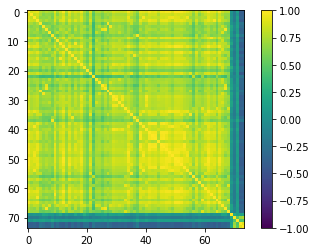

,VTI,SPTM,IXN,VIS,IYR,EWZ,VDE,FXI,VPU,VCR,...,XLV,DIA,EEM,XLE,PPH,GLD,TIP,LQD,TLT,IEF
VTI,1.000000,0.874032,0.908474,0.935760,0.784825,0.725067,0.781091,0.735558,0.715034,0.928490,...,0.828526,0.963858,0.846202,0.780647,0.781658,0.050460,-0.169573,0.137284,-0.413045,-0.402994
SPTM,0.874032,1.000000,0.813975,0.855297,0.739293,0.628250,0.672949,0.656638,0.605816,0.844529,...,0.706793,0.845677,0.739309,0.684152,0.675504,0.021784,-0.180869,0.041749,-0.395530,-0.390168
IXN,0.908474,0.813975,1.000000,0.833987,0.670844,0.675606,0.657394,0.708618,0.591379,0.858729,...,0.727634,0.870259,0.808089,0.654222,0.683015,0.055647,-0.158921,0.133869,-0.363048,-0.358632
VIS,0.935760,0.855297,0.833987,1.000000,0.752864,0.690452,0.760820,0.689471,0.649736,0.891841,...,0.740823,0.921489,0.793111,0.754623,0.700288,0.029920,-0.176778,0.109340,-0.420418,-0.411690
IYR,0.784825,0.739293,0.670844,0.752864,1.000000,0.567091,0.565640,0.594224,0.633056,0.765145,...,0.578187,0.742990,0.683099,0.565272,0.552549,0.050858,-0.098125,0.135713,-0.237456,-0.234246
EWZ,0.725067,0.628250,0.675606,0.690452,0.567091,1.000000,0.691474,0.687005,0.559497,0.645134,...,0.543694,0.701288,0.834757,0.689225,0.528428,0.180725,-0.057231,0.163644,-0.288678,-0.275663
VDE,0.781091,0.672949,0.657394,0.760820,0.565640,0.691474,1.000000,0.618239,0.584692,0.664342,...,0.579016,0.760044,0.727975,0.988083,0.568269,0.160815,-0.073870,0.111601,-0.359865,-0.335616
FXI,0.735558,0.656638,0.708618,0.689471,0.594224,0.687005,0.618239,1.000000,0.513776,0.672954,...,0.566737,0.711172,0.893423,0.618700,0.548833,0.094576,-0.162521,0.111763,-0.318691,-0.341356
VPU,0.715034,0.605816,0.591379,0.649736,0.633056,0.559497,0.584692,0.513776,1.000000,0.605303,...,0.630757,0.714071,0.614229,0.589604,0.595782,0.104062,-0.051022,0.213702,-0.204574,-0.186291
VCR,0.928490,0.844529,0.858729,0.891841,0.765145,0.645134,0.664342,0.672954,0.605303,1.000000,...,0.732895,0.884817,0.772409,0.658766,0.689500,0.000638,-0.163802,0.114292,-0.376429,-0.375201


In [6]:
import matplotlib.pyplot as plt
from mypo import clustering_tickers, evaluate_combinations

CLUSTERS = 3
cluster = clustering_tickers(market, n=CLUSTERS)
corr = market.get_rate_of_change()[cluster.index].corr()

plt.figure()
plt.imshow(corr,interpolation='nearest',vmin=-1,vmax=1,cmap='viridis')
plt.colorbar()
plt.show()

corr

In [7]:
from mypo import split_k_folds, select_by_regression
from mypo.optimizer import MaximumDiversificationOptimizer, MeanVarianceOptimizer
from mypo.rebalancer import MonthlyRebalancer
from mypo import Runner

folds = split_k_folds(market, 4, 200)


Traditional Asset Class
----------------------------

100%|██████████| 984/984 [00:10<00:00, 89.56it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TLT, GLD, SPY]             1.054379        0.85498                 174


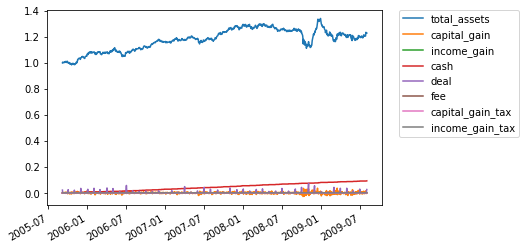

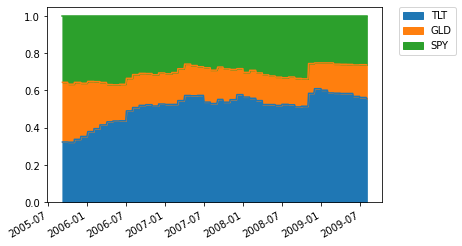

100%|██████████| 984/984 [00:11<00:00, 87.83it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TLT, GLD, SPY]             1.108893        0.93276                 100


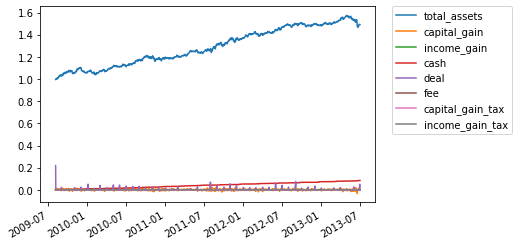

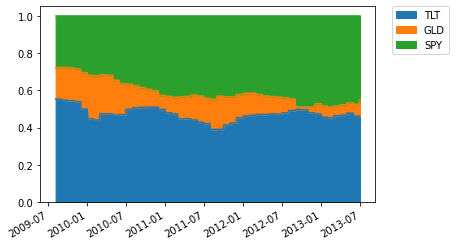

100%|██████████| 984/984 [00:11<00:00, 87.20it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TLT, GLD, SPY]             1.078098       0.919568                 295


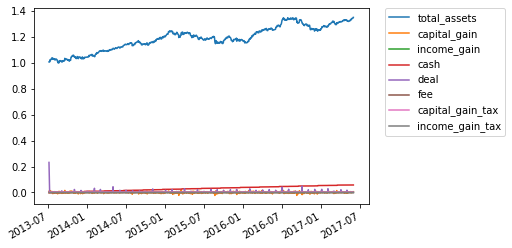

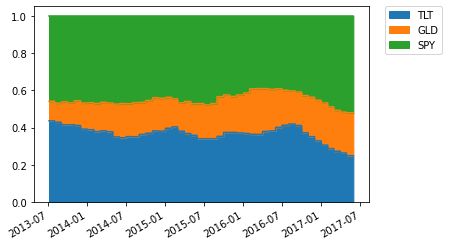

100%|██████████| 984/984 [00:11<00:00, 88.08it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TLT, GLD, SPY]             1.086937        0.84886                 291


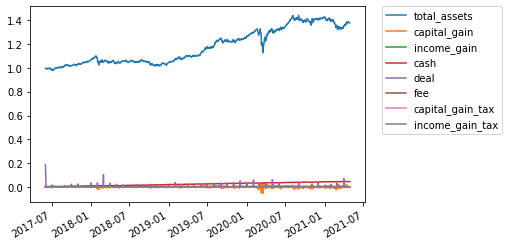

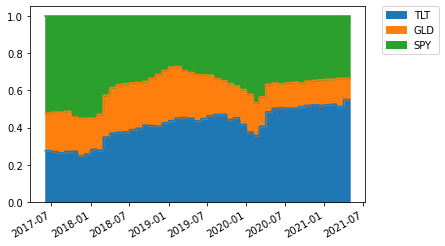

In [8]:
for i in range(len(folds)):
    selected_tickers = ['SPY', 'TLT', 'GLD']
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer(do_re_optimize=True)
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()


Select Tickers from clusters
----------------------------------

100%|██████████| 984/984 [00:12<00:00, 81.04it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [EWZ, GLD, IEF]             1.077544       0.869239                 304


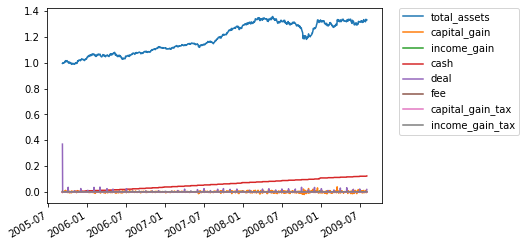

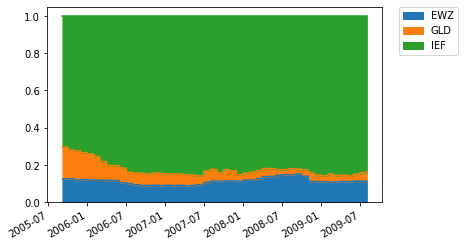

100%|██████████| 984/984 [00:12<00:00, 79.77it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [RWR, TIP, IEF]             1.068908       0.920603                 154


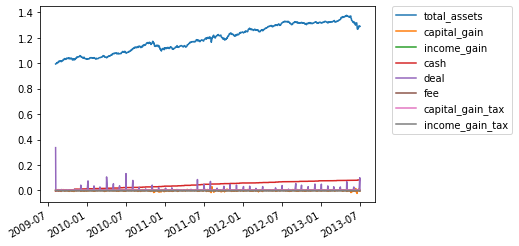

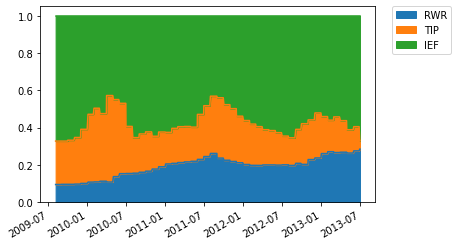

100%|██████████| 984/984 [00:12<00:00, 81.48it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [FEZ, GLD, IEF]             1.030963       0.930154                 312


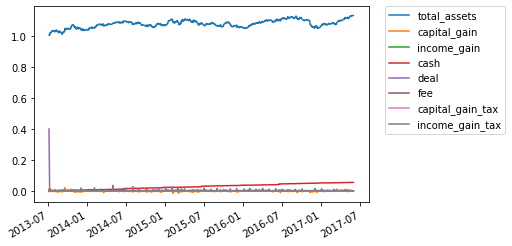

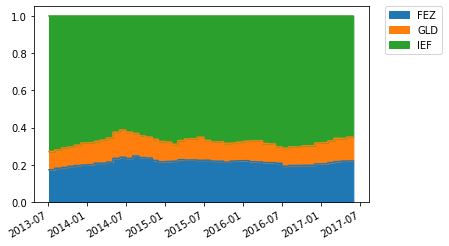

100%|██████████| 984/984 [00:11<00:00, 82.35it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [GLD, XLF, IEF]             1.040741       0.906438                 289


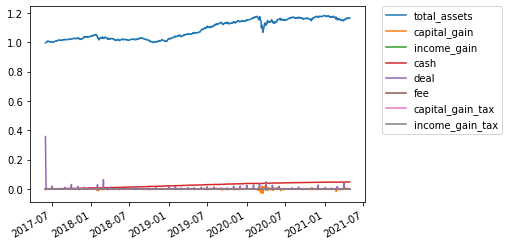

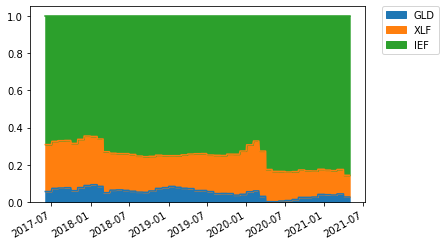

In [9]:
for i in range(len(folds)):
    evaluates = evaluate_combinations(folds[i].get_train(), cluster, optimizer=MaximumDiversificationOptimizer(), verbose=True)
    fold = folds[i].filter((list(evaluates['combinations'])[0]))
    optimizer = MaximumDiversificationOptimizer(do_re_optimize=True)
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Select Tickers by dayly return
----------------------------------

100%|██████████| 984/984 [00:12<00:00, 81.56it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TLT, TIP, ILF]             1.050952       0.811549                 304


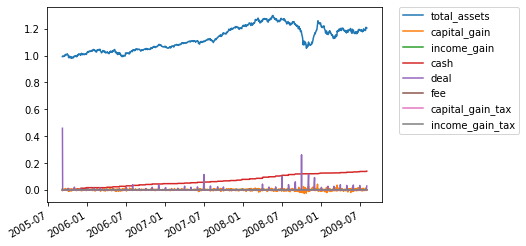

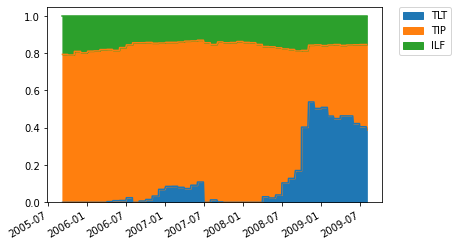

100%|██████████| 984/984 [00:12<00:00, 81.40it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [EWZ, GLD, IEF]              1.02941       0.900265                 338


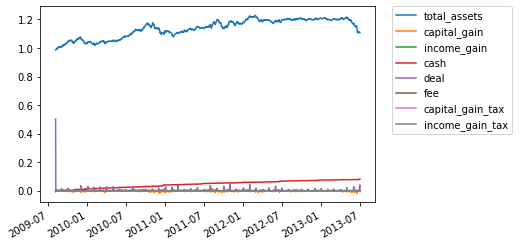

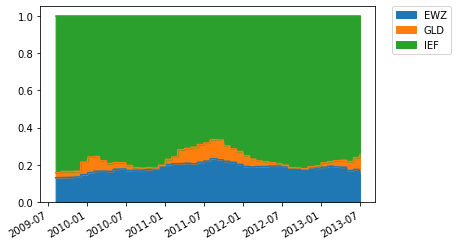

100%|██████████| 984/984 [00:11<00:00, 84.55it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [LQD, BBH, IEF]             1.043715       0.928769                 327


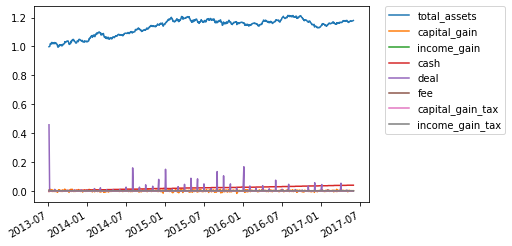

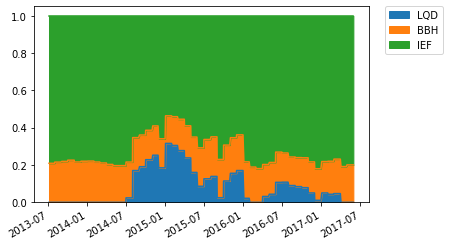

100%|██████████| 984/984 [00:11<00:00, 84.83it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [IXN, TIP, IEF]             1.057576       0.919638                 165


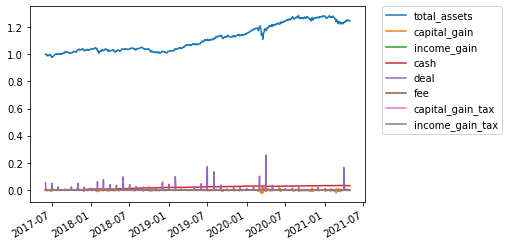

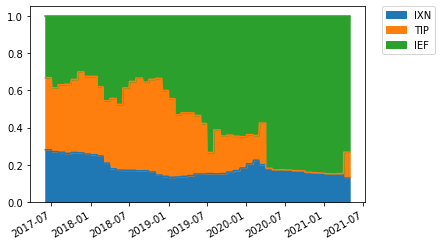

In [10]:
for i in range(len(folds)):
    df = pd.concat([folds[i].get_train().get_summary(), cluster], axis=1)
    selected_tickers = list(df.groupby('class').idxmax().reset_index(drop=True)['daily return'])
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer(do_re_optimize=True)
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Select Tickers by Regression
----------------------------------

100%|██████████| 984/984 [00:12<00:00, 75.92it/s]


                tickers  yearly total return  max draw down  \
0  [TLT, EWG, SPY, ILF]              1.06894       0.837406   

   max draw down span  
0                 156  


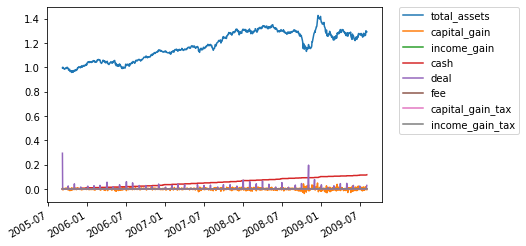

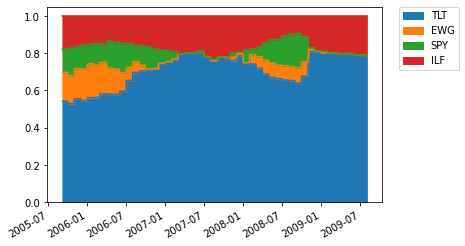

100%|██████████| 984/984 [00:11<00:00, 87.58it/s]


      tickers  yearly total return  max draw down  max draw down span
0  [SPY, IEF]             1.073707       0.951708                 119


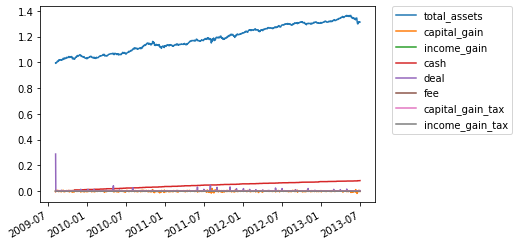

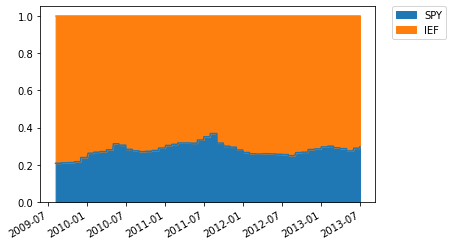

100%|██████████| 984/984 [00:10<00:00, 92.65it/s]


      tickers  yearly total return  max draw down  max draw down span
0  [SPY, IEF]              1.05523       0.954674                 210


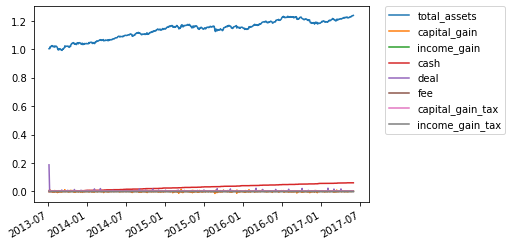

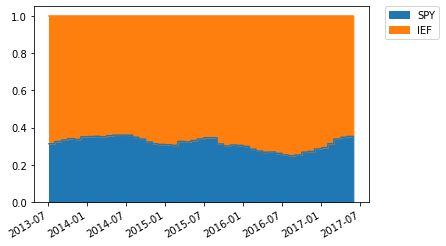

100%|██████████| 984/984 [00:13<00:00, 75.48it/s]


                tickers  yearly total return  max draw down  \
0  [SPY, EWY, TIP, ILF]             1.047854        0.85952   

   max draw down span  
0                 341  


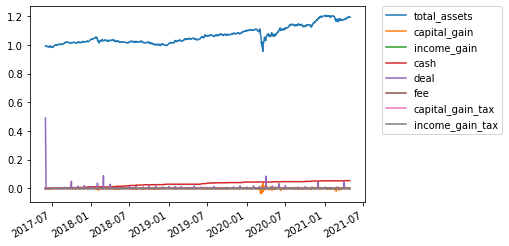

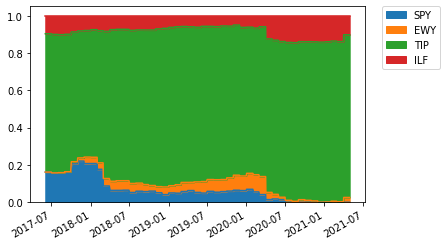

In [11]:
for i in range(len(folds)):
    selected_tickers = select_by_regression(folds[i].get_train(), threshold=0.8)
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer(do_re_optimize=True)
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()